In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes

In [2]:
time = ['2016-01-01T00:00:00Z', '2016-02-01T00:00:00Z']

file_name = f"./data/wind_{time[0]}_{time[1]}_1min_nonlin.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_nonlin',
                                               'Proton_VY_nonlin',
                                               'Proton_VZ_nonlin',
                                               'Proton_Np_nonlin',
                                               'Proton_W_nonlin'],
                                 time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = np.column_stack([data.Proton_VX_nonlin.values,
                                data.Proton_VY_nonlin.values,
                                data.Proton_VZ_nonlin.values])
    velocity[np.any(velocity == data.Proton_VX_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_nonlin.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_nonlin.values
    density[density == data.Proton_Np_nonlin.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    temperature = data.Proton_W_nonlin.values
    temperature[temperature == data.Proton_W_nonlin.FILLVAL] = np.nan
    temperature = (temperature * 1e3) ** 2 * scipy.constants.m_p / (2 * scipy.constants.Boltzmann) / 1e6
    temperature = pd.Series(temperature, index=pd.DatetimeIndex(datetime)).interpolate()
    temperature = temperature.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    temperature = temperature.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, temperature=temperature, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
temperature = torch.as_tensor(data["temperature"], dtype=torch.float32)
times = data["times"]

In [3]:
durations = range(10, 300)

gas_pressure = scipy.constants.Boltzmann * (density * 1e6) * (temperature * 1e6) * 1e9

results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size=10000,
                            window_steps=[max(duration // 64, 1) for duration in durations],
                            window_lengths=durations,
                            min_strength=0,
                            frame_type="vht",
                            max_processing_resolution=64)


100%|██████████| 290/290 [00:20<00:00, 14.15it/s]


In [4]:
print(len(results), 'detected')

211 detected


2016-01-01T03:01:30.000000000  to  2016-01-01T03:22:30.000000000
duration: 22
error: 0.15 0.12
walen slope: 0.214
<B>: 13.25
Altitude/azimuth: 158 / 12
Frame quality: 0.9999746084213257
Field alignment 0.9983916282653809


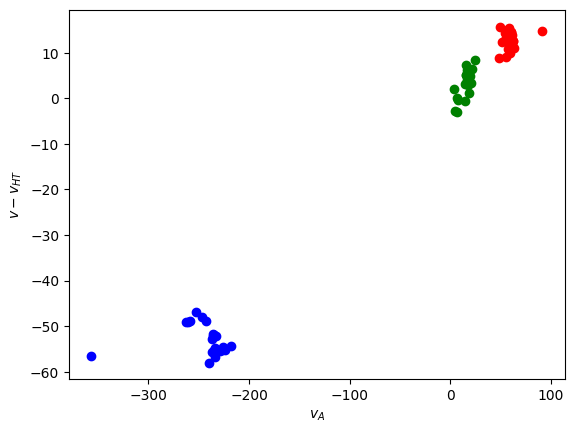

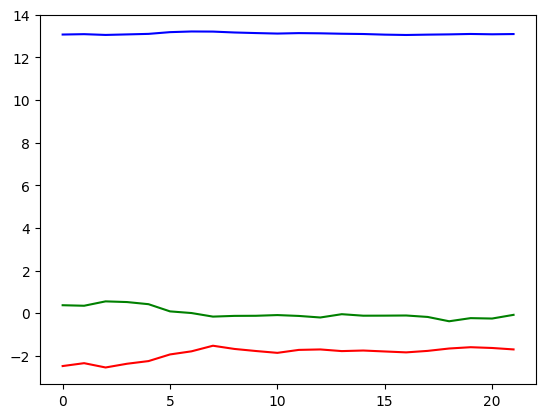

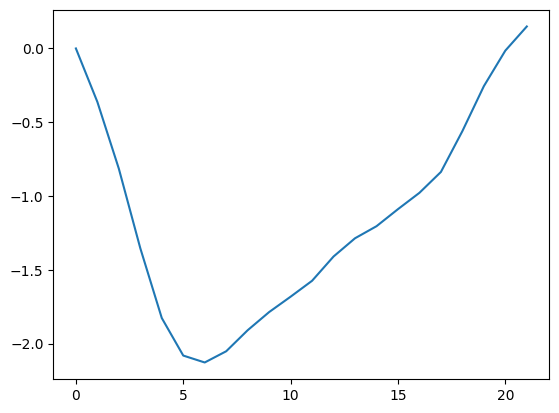

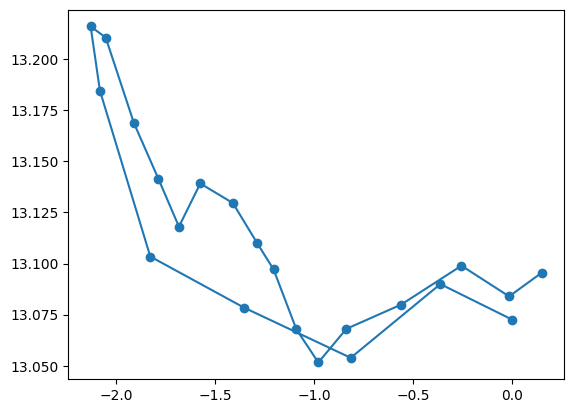

2016-01-01T05:12:30.000000000  to  2016-01-01T06:59:30.000000000
duration: 108
error: 0.15 0.133
walen slope: 0.107
<B>: 10.42
Altitude/azimuth: 111 / 339
Frame quality: 0.9996410608291626
Field alignment 0.6492722034454346


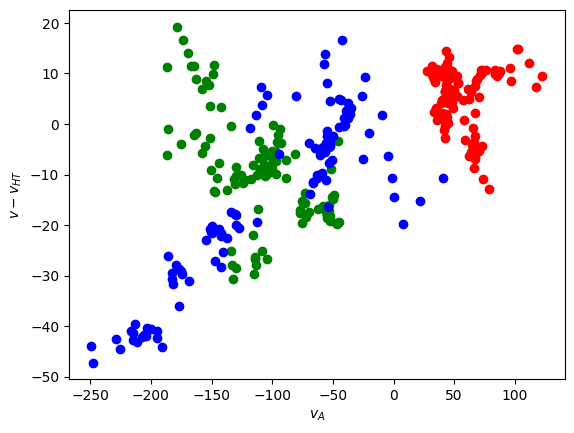

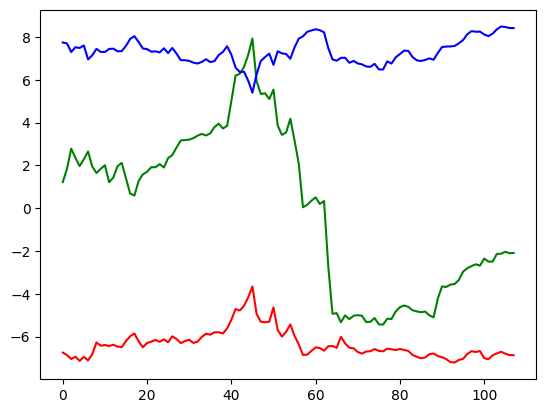

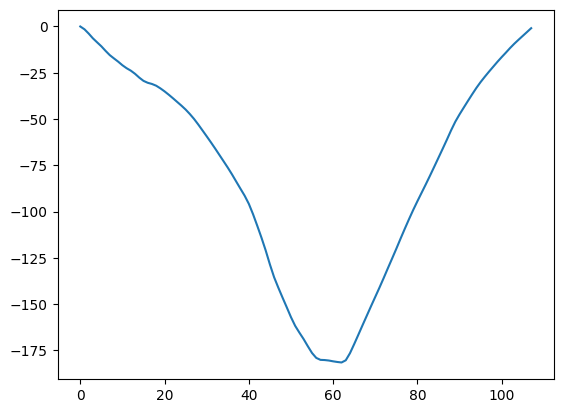

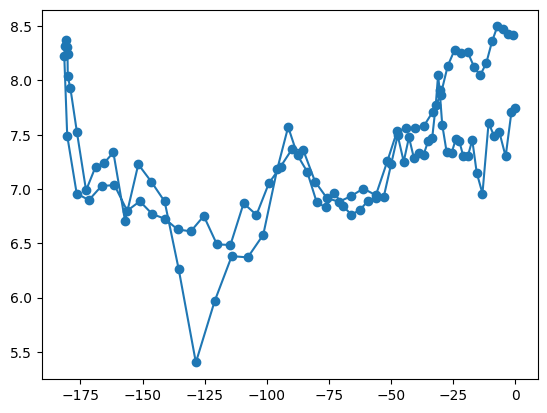

2016-01-01T07:21:30.000000000  to  2016-01-01T12:05:30.000000000
duration: 285
error: 0.092 0.118
walen slope: -0.103
<B>: 9.78
Altitude/azimuth: 91 / 286
Frame quality: 0.9984997510910034
Field alignment -0.7574249505996704


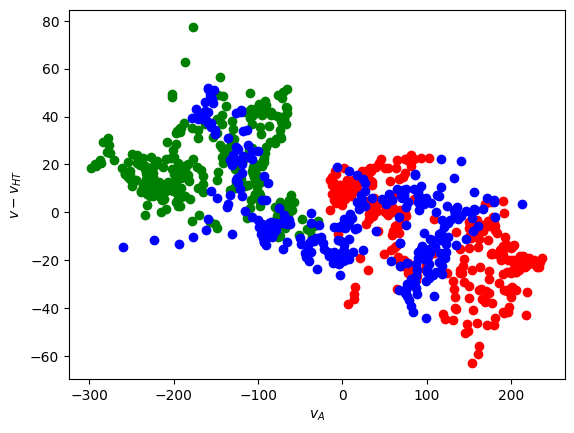

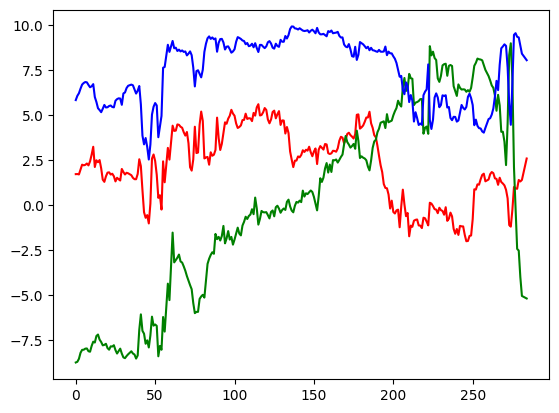

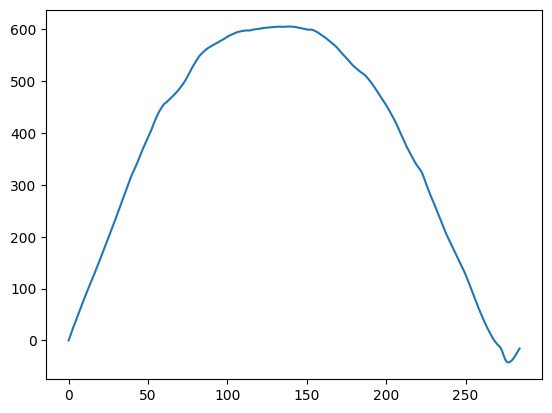

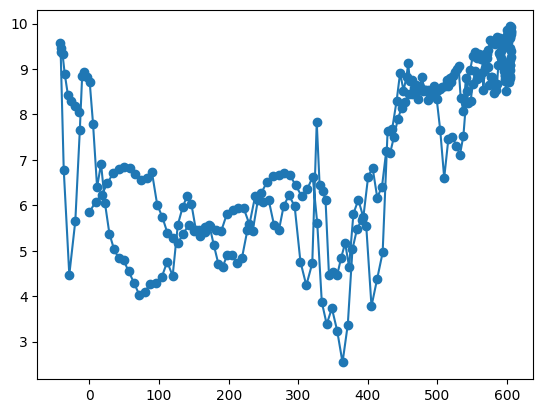

2016-01-01T13:32:30.000000000  to  2016-01-01T13:52:30.000000000
duration: 21
error: 0.115 0.125
walen slope: -0.031
<B>: 9.17
Altitude/azimuth: 99 / 320
Frame quality: 0.9999080300331116
Field alignment -0.886352002620697


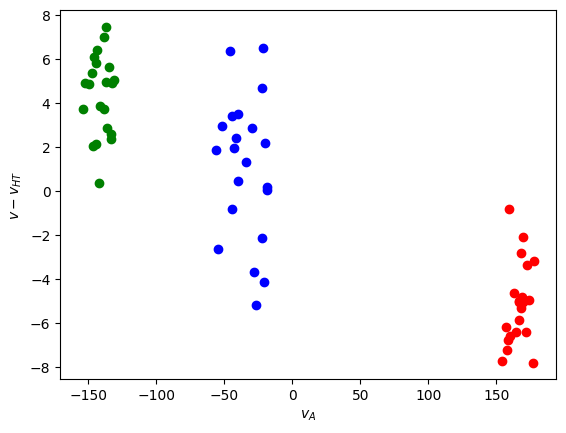

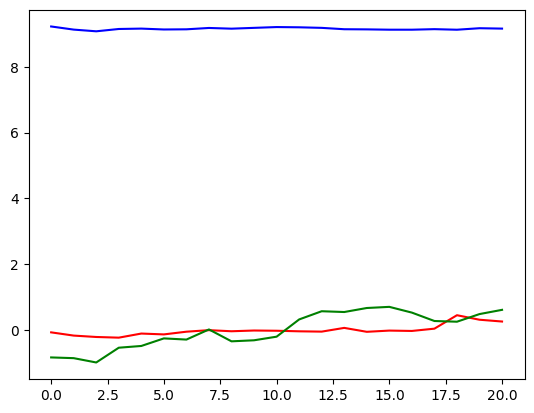

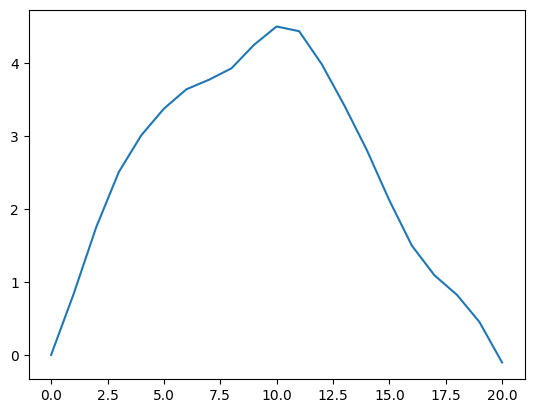

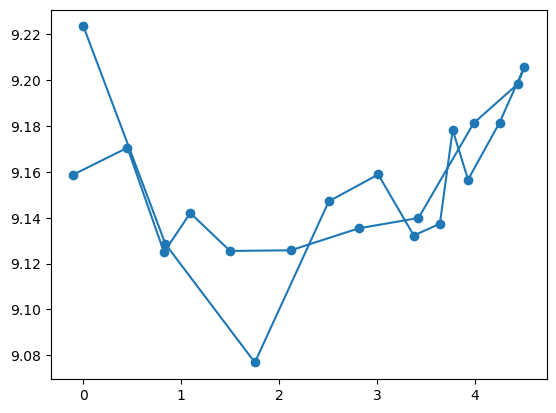

2016-01-01T14:19:30.000000000  to  2016-01-01T16:12:30.000000000
duration: 114
error: 0.123 0.127
walen slope: 0.076
<B>: 8.95
Altitude/azimuth: 89 / 309
Frame quality: 0.9996609687805176
Field alignment 0.7671588659286499


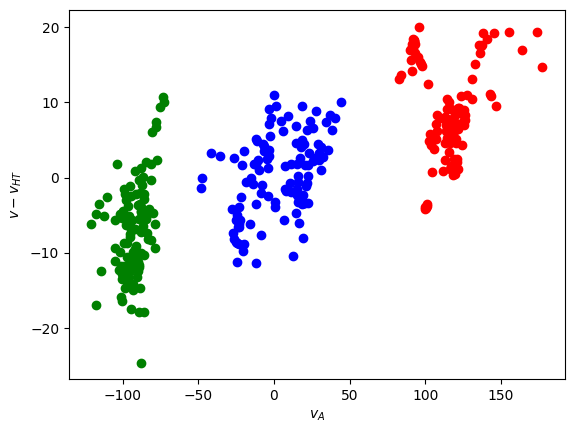

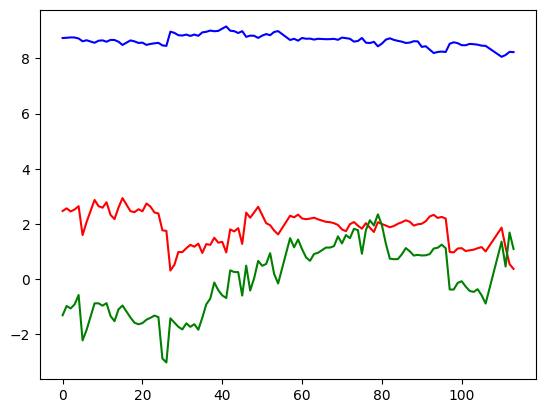

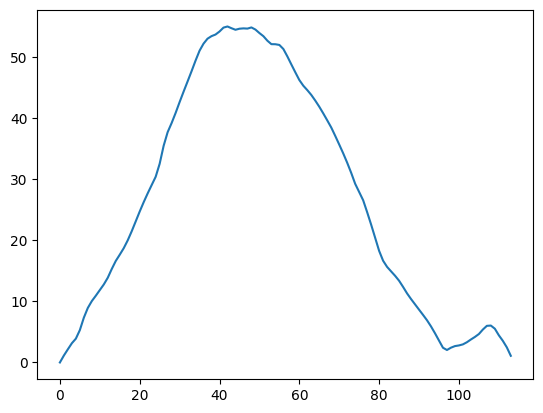

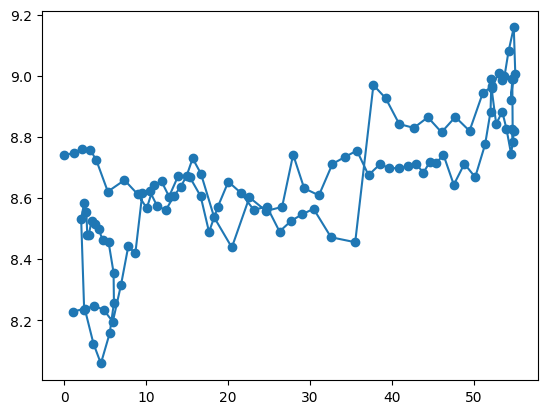

2016-01-01T19:32:30.000000000  to  2016-01-01T21:31:30.000000000
duration: 120
error: 0.127 0.095
walen slope: 0.213
<B>: 4.85
Altitude/azimuth: 99 / 25
Frame quality: 0.998790979385376
Field alignment 0.35085195302963257


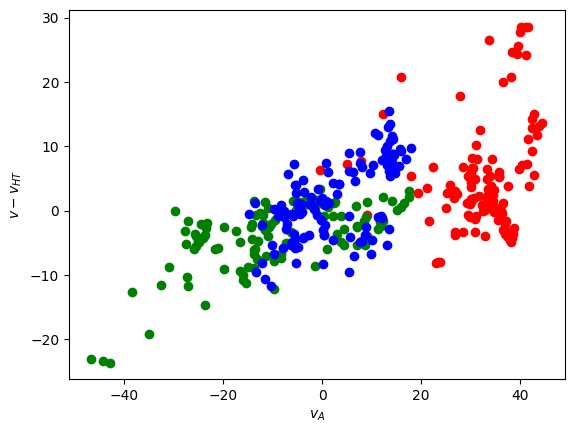

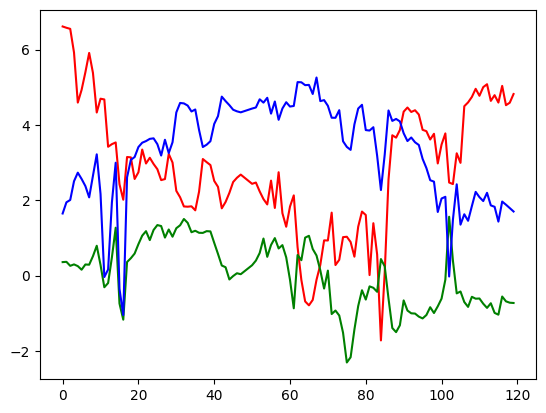

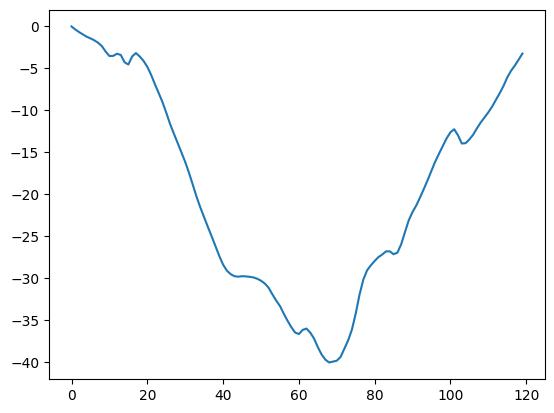

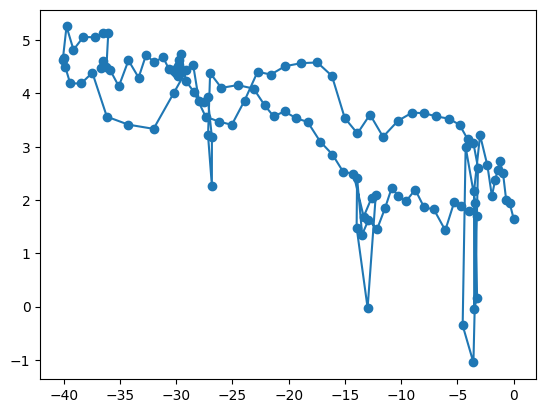

2016-01-02T01:01:30.000000000  to  2016-01-02T03:43:30.000000000
duration: 163
error: 0.151 0.137
walen slope: 0.147
<B>: 9.4
Altitude/azimuth: 88 / 296
Frame quality: 0.9983813166618347
Field alignment 0.9188157320022583


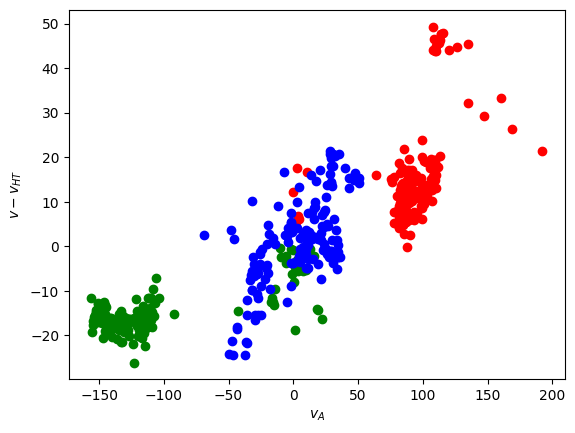

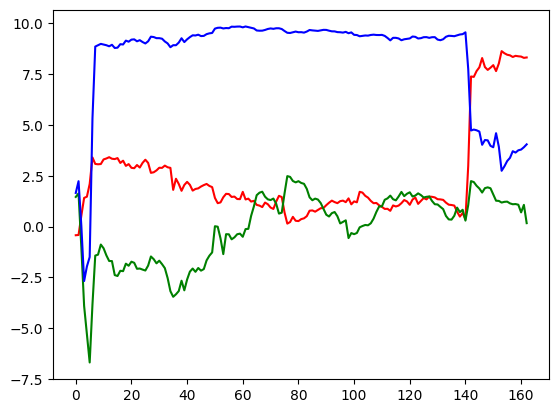

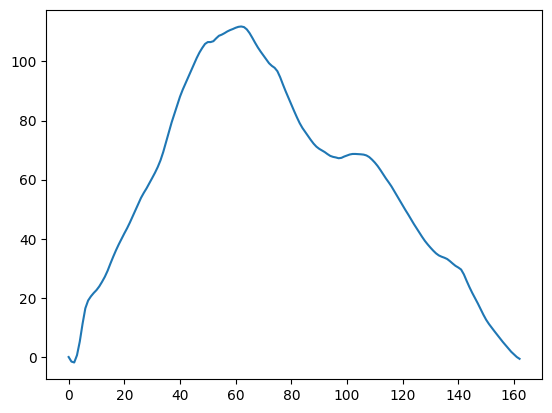

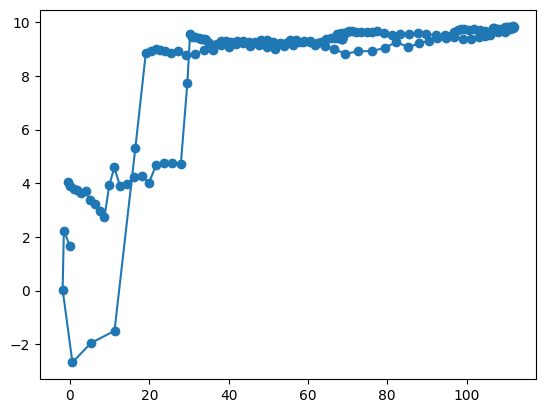

2016-01-02T07:43:30.000000000  to  2016-01-02T08:13:30.000000000
duration: 31
error: 0.183 0.137
walen slope: 0.08
<B>: 5.83
Altitude/azimuth: 108 / 320
Frame quality: 0.999774694442749
Field alignment 0.2538202404975891


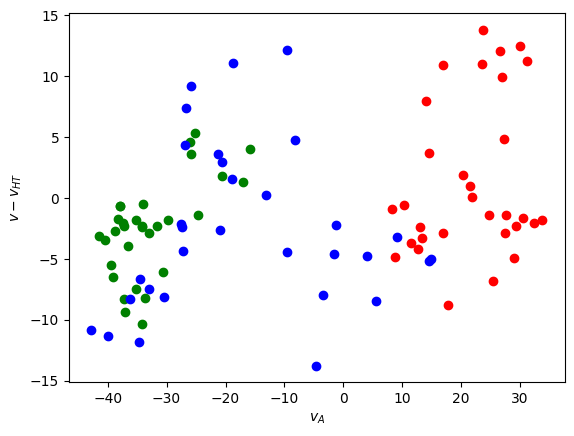

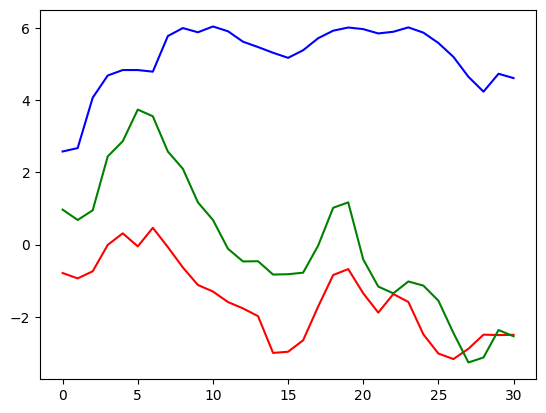

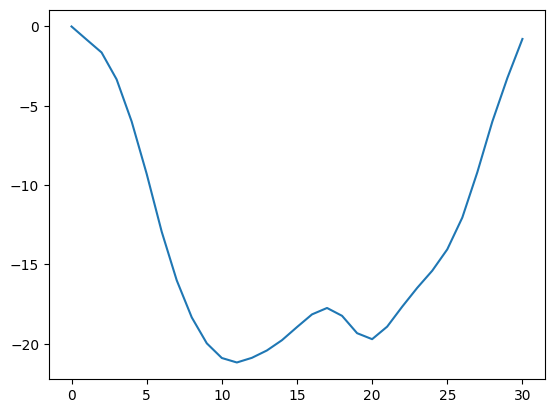

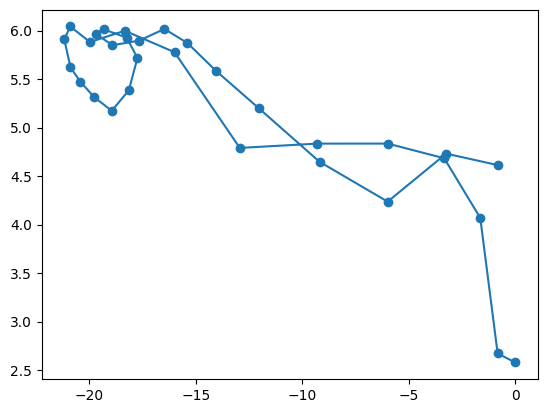

2016-01-02T11:13:30.000000000  to  2016-01-02T12:23:30.000000000
duration: 71
error: 0.12 0.092
walen slope: -0.208
<B>: 5.05
Altitude/azimuth: 79 / 277
Frame quality: 0.9999578595161438
Field alignment -0.8415449261665344


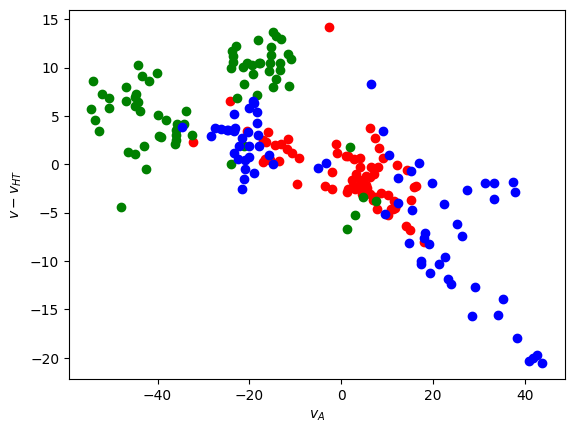

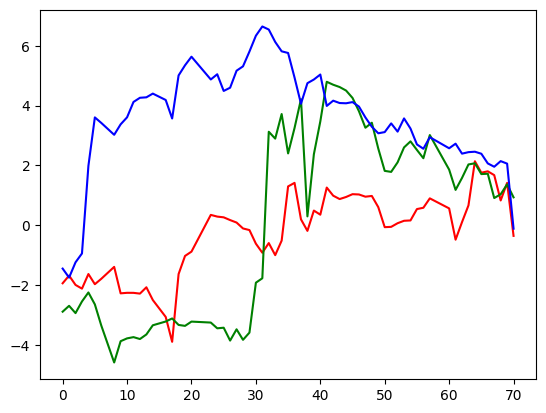

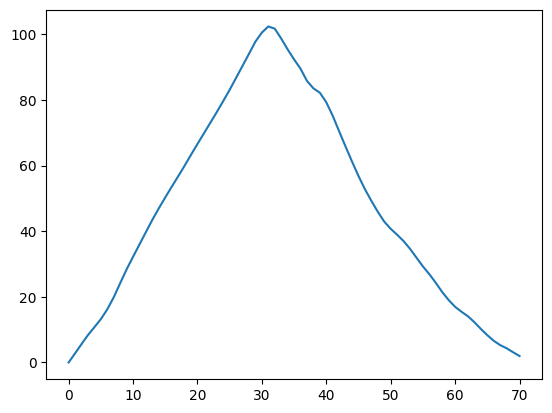

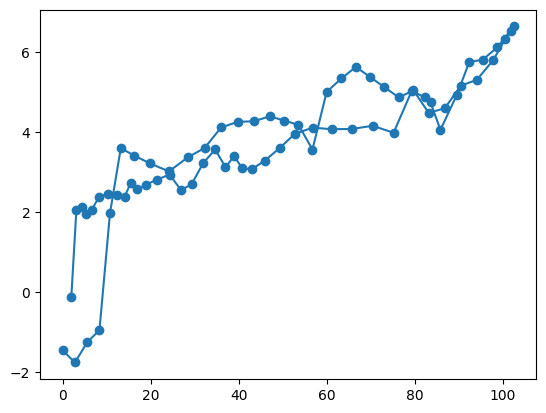

2016-01-02T15:15:30.000000000  to  2016-01-02T15:53:30.000000000
duration: 39
error: 0.135 0.127
walen slope: -0.262
<B>: 5.53
Altitude/azimuth: 82 / 182
Frame quality: 0.9993250370025635
Field alignment -0.9569056630134583


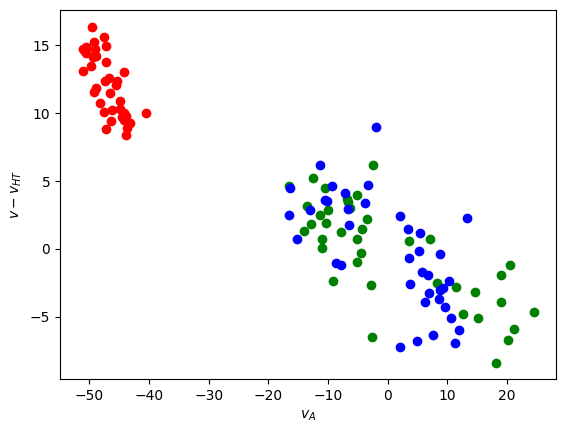

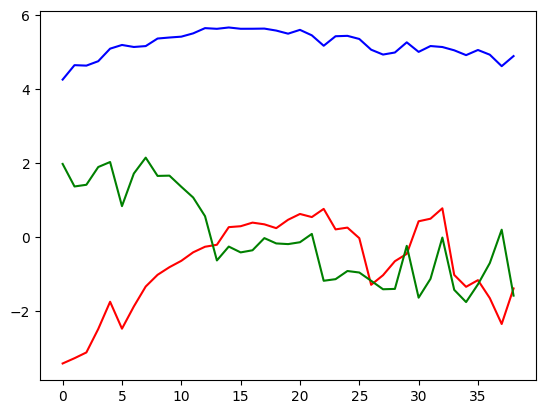

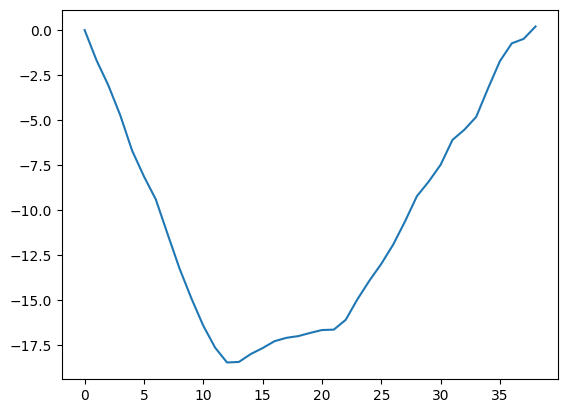

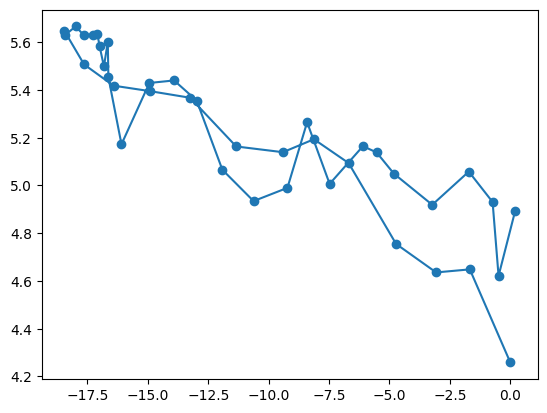

In [5]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for i_result in results[results.duration > 20].index[:10]:
    axis = results[["axis_x", "axis_y", "axis_z"]].iloc[i_result]
    frame = results[["frame_x", "frame_y", "frame_z"]].iloc[i_result]
    start = results.start.iloc[i_result]
    duration = results.duration.iloc[i_result]
    end = results.end.iloc[i_result]
    residue = results.error_diff.iloc[i_result]
    error_fit = results.error_fit.iloc[i_result]

    z_unit = np.array(axis)
    frame = np.array(frame)

    event_velocity = velocity[start:start + duration].cpu().numpy()
    event_field = magnetic_field[start:start + duration].cpu().numpy()

    x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(z_unit, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

    event_density = density[start:start + duration].cpu().numpy()

    alfven_velocity = event_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    Pgas = gas_pressure[start:start + duration].cpu().numpy()
    remaining_flow = event_velocity - frame

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    # if walen_slope > 0.3:
    #     continue

    print(times[start], " to ", times[end])
    print("duration:", duration)
    print("error:", round(residue, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("<B>:", round(np.linalg.norm(event_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))
    print("Frame quality:", results.frame_quality[i_result])
    print("Field alignment", results.flow_field_alignment[i_result])

    colors = ["red", "green", "blue"]

    for i, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i], remaining_flow[:, i], color=color)
        plt.xlabel(r"$v_A$")
        plt.ylabel(r"$v - v_{HT}$")
    plt.show()

    rotated = rotation_matrix @ event_field.T
    for i_color, color in enumerate(colors):
        plt.plot(rotated[i_color], color=color)
    plt.show()

    dx = np.linalg.norm(np.dot(frame, x_unit))
    A = scipy.integrate.cumulative_trapezoid(-rotated[1], initial=0)
    plt.plot(A)
    plt.show()

    P = Pgas + (rotated[2] * 1e-9) ** 2 / (2 * 1.25663706212e-6) * 1e9
    plt.scatter(A, rotated[2])
    plt.plot(A, rotated[2])
    plt.show()